# Old notebook, repurposed for project write-up
* Took a copy Mon 13-Aug
* Aim is to use this notebook to get some plots and examples for the WORLD feature section
* Want plots of features
* Example of what happens to the sound if you mess with Lf0 (put these on website)
* Examples of how close VoiceLoop gets?

# WORLD Features Exploration
* Loads the pre-calculated WORLD features for a specified sample
* Visualise the features
* Investigate the impact of modifying the features on the synthesized speech

## 1) Setup

In [34]:
import sys
sys.path.append('..')
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from data import *
from model import Loop
from utils import generate_merlin_wav

from torch.autograd import Variable
from IPython.display import Audio
import IPython.display

import phonemizer

import pandas as pd
from scipy.io import wavfile
import spectrogram as sp

import torch
import copy
from shutil import copyfile

In [2]:
os.chdir('/home/ubuntu/loop')
vctk_folder = '/home/ubuntu/VCTK-Corpus/'

In [3]:
os.getcwd()

'/home/ubuntu/loop'

In [4]:
def text2phone(text, char2code):
    seperator = phonemizer.separator.Separator('', '', ' ')
    ph = phonemizer.phonemize(text, separator=seperator)
    ph = ph.split(' ')
    ph.remove('')

    ph = [p.replace('zh', 'jh') for p in ph]

    result = [char2code[p] for p in ph]
    return torch.LongTensor(result)

In [5]:
def trim_pred(out, attn):
    tq = attn.abs().sum(1).data

    for stopi in range(1, tq.size(0)):
        col_sum = attn[:stopi, :].abs().sum(0).data.squeeze()

        if type(tq[stopi]) == float:
            if tq[stopi] < 0.5 and col_sum[-1] > 4:
                break
        else:  
            if tq[stopi][0] < 0.5 and col_sum[-1] > 4:
                break

    out = out[:stopi, :]
    attn = attn[:stopi, :]

    return out, attn

In [6]:
def npy_loader_phonemes(path):
    feat = np.load(path)

    txt = feat['phonemes'].astype('int64')
    txt = torch.from_numpy(txt)

    audio = feat['audio_features']
    audio = torch.from_numpy(audio)

    return txt, audio, feat

In [7]:
def load_pre_calc_features(speaker_id, sample_id):
    pre_calc_features_folder = '/home/ubuntu/loop/data/vctk/numpy_features/'
    pre_calc_features_file = os.path.join(pre_calc_features_folder, 
                                      'p' + str(speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz')
    
    feats = np.load(pre_calc_features_file)
    
    return feats

In [8]:
def play_synthesized_features(feats):
    output_dir = './'
    output_file = 'test.wav'
    norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
    
    if isinstance(feats, dict):
        feats = feats['audio_features']
    
    generate_merlin_wav(feats,
                        output_dir,
                        output_file,
                        norm_path)

    IPython.display.display(IPython.display.Audio(output_file + '.wav', autoplay=True))
    
    rate, wav_data = wavfile.read(output_file + '.wav')  
    
    return rate, wav_data

In [9]:
def get_vtck_speaker_info():
    # this is the reference data file that comes as part of VCTK
    speaker_info_file = os.path.join(vctk_folder, 'speaker-info.txt')

   # read file contents
    f = open(speaker_info_file, 'r')
    x = f.readlines()
    f.close()

    # extract column headers
    cols = x[0].lower().split()
    num_cols = len(cols)
    del x[0]
    num_speaker = len(x)

    # parse the data line by line
    d = dict()

    for idx in range(num_speaker):
        this_speaker_id = int(x[idx][:3])
        this_age = int(x[idx][5:7])
        this_gender = x[idx][9]
        residual = x[idx][14:].split()
        this_accent = residual[0]
        this_region = " ".join(residual[1:])

        # add speakers to a dictionary
        d[this_speaker_id] = (this_speaker_id, this_age, this_gender, this_accent, this_region)

    # convert to Pandas datafrae
    speaker_info = pd.DataFrame.from_dict(d, orient='index', columns=cols)
    
    return speaker_info

In [280]:
def generate_sample_with_loop(npz='', text='', spkr_id=1, checkpoint='models/vctk/bestmodel.pth', output_dir = './',
                             npz_path = '/home/ubuntu/loop/data/vctk/numpy_features', b_eval_mode=True):
    #npz = ''
    #text = 'Your tickets for the social issues'
    #text = 'see that girl watch that scene'
    #npz = '/home/ubuntu/loop/data/vctk/numpy_features/p294_011.npz'
    #spkr_id = 12
    #checkpoint = 'checkpoints/vctk/lastmodel.pth'
    #checkpoint = 'models/vctk/bestmodel.pth'
    
    out_dict = dict()
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    gpu = 0

    # load loop weights & params from checkpoint
    weights = torch.load(checkpoint,
                         map_location=lambda storage, loc: storage)
    opt = torch.load(os.path.dirname(checkpoint) + '/args.pth')
    train_args = opt[0]

    train_dataset = NpzFolder('/home/ubuntu/loop/data/vctk/numpy_features')
    char2code = train_dataset.dict
    spkr2code = train_dataset.speakers

    norm_path = train_args.data + '/norm_info/norm.dat'
    norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'
    train_args.noise = 0
    
    valid_dataset_path = npz_path + '_valid'

    
    # prepare loop model
    model = Loop(train_args)
    model.load_state_dict(weights)
    if gpu >= 0:
        model.cuda()
    
    if b_eval_mode:
        model.eval()
    else:
        model.train()
        model.noise = 0
    
    # check speaker id is valid
    if spkr_id not in range(len(spkr2code)):
        print('ERROR: Unknown speaker id: %d.' % spkr_id)

    # get phone sequence
    txt, feat, spkr, output_fname = None, None, None, None
    if npz is not '':
        # use pre-calculated phonemes etc.
        txt, feat, pre_calc_feat = npy_loader_phonemes(os.path.join(npz_path, npz))

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(torch.LongTensor([spkr_id]), volatile=True)

        output_file = os.path.basename(npz)[:-4] + '_' + str(spkr_id)
        
        out_dict['pre_calc_feat'] = pre_calc_feat
        
    elif text is not '':
        # use specified text string
        # extract phonemes from the text
        txt = text2phone(text, char2code)
        feat = torch.FloatTensor(txt.size(0)*20, 63)
        spkr = torch.LongTensor([spkr_id])

        txt = Variable(txt.unsqueeze(1), volatile=True)
        feat = Variable(feat.unsqueeze(1), volatile=True)
        spkr = Variable(spkr, volatile=True)

        output_file = text.replace(' ', '_')
    else:
        print('ERROR: Must supply npz file path or text as source.')
        raise Exception('Need source')

    # use gpu
    if gpu >= 0:
        txt = txt.cuda()
        feat = feat.cuda()
        spkr = spkr.cuda()
    print model.training
    # run loop model to generate output features 
    loop_feat, attn = model([txt, spkr], feat)
    loop_feat, attn = trim_pred(loop_feat, attn)
    
    # add to output dictionary
    out_dict['txt'] = txt[:,0].squeeze().data.tolist()
    out_dict['spkr'] = spkr
    out_dict['feat'] = feat.data.cpu().numpy()
    out_dict['loop_feat'] = loop_feat.data.cpu().numpy()
    out_dict['attn'] = attn.squeeze().data.cpu().numpy()
    out_dict['output_file'] = output_file
    out_dict['valid_dataset_path'] = valid_dataset_path
    


    # generate .wav file from loop output features
    generate_merlin_wav(loop_feat.data.cpu().numpy(),
                        output_dir,
                        output_file,
                        norm_path)
    
    
    # generate .wav file from original features for reference
    if npz is not '':
        output_orig_fname = os.path.basename(npz)[:-4] + '.orig'
        generate_merlin_wav(feat[:, 0, :].data.cpu().numpy(),
                            output_dir,
                            output_orig_fname,
                            norm_path)
        out_dict['output_orig_fname'] = output_orig_fname
    
    return out_dict

In [181]:
def plot_attn(data, labels, dict_file, title=None, fname=None):
    labels_dict = dict_file
    labels_dict = {v: k for k, v in labels_dict.iteritems()}
    labels = [labels_dict[x].decode('latin-1') for x in labels]

    plt.figure(figsize=(12,12))
    axarr = plt.subplot()
    axarr.imshow(data.T, aspect='auto', origin='lower', interpolation='nearest', cmap=cm.viridis)
    axarr.set_yticks(np.arange(0, len(data.T)))
    axarr.set_yticklabels(labels, rotation=90)
    plt.yticks(fontsize=10, rotation=90)
    plt.xlabel('Frame')
    plt.ylabel('Phoneme')
    if title:
        plt.title(title)
    
    if fname:
        plt.savefig(fname)

In [38]:
def display_vctk_sample(vctk_speaker_id, sample_id, fname=None, save_folder=''):
    # raw .wav file
    wav_file = os.path.join(vctk_folder, 'wav48/p' + str(vctk_speaker_id) + '/p' + str(vctk_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.wav')

    # print speaker info
    display(speaker_info[speaker_info['id']==vctk_speaker_id])

    # print text
    txt_file = wav_file.replace("wav48", "txt").replace(".wav", ".txt")
    f = open(txt_file, 'r')
    print(f.read())
    f.close()

    # play sample
    rate, wav_data = wavfile.read(wav_file)    
    display(IPython.display.Audio(data=wav_data, rate=rate, autoplay=True))

    if fname: 
        copyfile(wav_file, os.path.join(save_folder, os.path.basename(wav_file)))
        
    # plot waveform
    plt.figure(figsize=(15,4))
    plt.plot(wav_data)
    plt.grid(True)
    plt.xlim(0, len(wav_data))
    plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

    if fname:
        plt.savefig(fname)
        
    # plot spectrogram
    plot_spectrogram(wav_data, rate)
    if fname:
        plt.savefig(fname + '_spectro')

In [13]:
def plot_spectrogram(wav_data, rate, title="Original Spectrogram"):
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    data = sp.butter_bandpass_filter(wav_data, lowcut, highcut, rate, order=1)
    #data = butter_bandpass_filter(data, 500, 7500, rate, order=1)
    # Only use a short clip for our demo
    if np.shape(data)[0]/float(rate) > 10:
        data = data[0:rate*10] 
    #print('Length in time (s):' + str(np.shape(data)[0]/float(rate)))

    wav_spectrogram = sp.pretty_spectrogram(wav_data.astype('float64'), fft_size = fft_size, 
                                       step_size = step_size, log = True, thresh = spec_thresh)

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    fig.colorbar(cax)
    plt.title(title)
    #plt.xlim(0, len(wav_data))
    #plt.xticks(range(0,len(wav_data), 48000), range(0, np.int(np.ceil(1.0*len(wav_data)/48000))))

In [260]:
 def plot_spectrogram_comparison(wav_file_a, wav_file_b, label_a='base', label_b='test',
                                 title="Original Spectrogram", b_mel=False, fname=None):
        
    ### Parameters ###
    fft_size = 480# 2048 # window size for the FFT
    #step_size = int(fft_size/16) # distance to slide along the window (in time)
    step_size = 160 # distance to slide along the window (in time)
    spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
    lowcut = 500 # Hz # Low cut for our butter bandpass filter
    highcut = 7500 #15000 # Hz # High cut for our butter bandpass filter

    # For mels
    n_mel_freq_components = 40# 64 # number of mel frequency channels
    shorten_factor = 1#10 # how much should we compress the x-axis (time)
    start_freq = 300 # Hz # What frequency to start sampling our melS from 
    end_freq = 8000 # Hz # What frequency to stop sampling our melS from

    #loop_dict['output_orig_fname']
    #loop_dict['output_fname']
    
    # load wav file data
    mywav_a = wav_file_a + '.wav'
    mywav_b = wav_file_b + '.wav'
    
    rate_a, data_a = wavfile.read(mywav_a)
    data_a = sp.butter_bandpass_filter(data_a, lowcut, highcut, rate_a, order=1)
    
    rate_b, data_b = wavfile.read(mywav_b)
    data_b = sp.butter_bandpass_filter(data_b, lowcut, highcut, rate_b, order=1)
    
    assert rate_a==rate_b, "Sampling rates don't match"
    
    # pad
    max_len = np.max([len(data_a), len(data_b)])
    
    tmp_a = data_a
    data_a = np.zeros(max_len)
    data_a[:len(tmp_a)] = tmp_a
    
    tmp_b = data_b
    data_b = np.zeros(max_len)
    data_b[:len(tmp_b)] = tmp_b
   

    # create spectrograms
    wav_spectrogram_a = sp.pretty_spectrogram(data_a.astype('float64'), fft_size = fft_size, 
                                           step_size = step_size, log = True, thresh = spec_thresh)
   
    wav_spectrogram_b = sp.pretty_spectrogram(data_b.astype('float64'), fft_size = fft_size, 
                                           step_size = step_size, log = True, thresh = spec_thresh)

    # create mel spectrograms if necessary
    if b_mel:        
         # Generate the mel filters
        mel_filter, mel_inversion_filter = sp.create_mel_filter(fft_size = fft_size,
                                                            n_freq_components = n_mel_freq_components,
                                                            start_freq = start_freq,
                                                            end_freq = end_freq, samplerate=rate_a) # may need to change sample rate
    
        # create mel spectrograms
        mel_spec_a = sp.make_mel(wav_spectrogram_a, mel_filter, shorten_factor = shorten_factor)
        mel_spec_b = sp.make_mel(wav_spectrogram_b, mel_filter, shorten_factor = shorten_factor)
        
        # use mel spectrograms in the plots (hacky, needs tidying up)
        wav_spectrogram_a = np.float64(mel_spec_a)
        wav_spectrogram_b = np.float64(mel_spec_b)

   
    # plot spectrograms and the differences
    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_a), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Spectrogram: ' + os.path.basename(wav_file_a) + '(' + label_a + ')')

    if fname:
        plt.savefig(fname + '_a')
        
    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_b), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Spectrogram: ' + os.path.basename(wav_file_b) + '(' + label_b + ')')

    if fname:
        plt.savefig(fname + '_b')
        
    f, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,3))
    cax = ax.matshow(np.transpose(wav_spectrogram_b - wav_spectrogram_a), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
    f.colorbar(cax)
    plt.title('Difference: (' + os.path.basename(wav_file_b) + ' - ' + os.path.basename(wav_file_a) + ') (' + label_b + ' - ' + label_a + ')')
    
    if fname:
        plt.savefig(fname + '_diff')

In [15]:
def plot_waveform_comparison(wav_file_a, wav_file_b, label_a='base', label_b='test',
                                 title="Original Spectrogram", b_mel=False):
        
    # load wav file data
    mywav_a = wav_file_a + '.wav'
    mywav_b = wav_file_b + '.wav'
    
    rate_a, data_a = wavfile.read(mywav_a)
    
    rate_b, data_b = wavfile.read(mywav_b)
    
    assert rate_a==rate_b, "Sampling rates don't match"
    
    # pad
    max_len = np.max([len(data_a), len(data_b)])
    
    tmp_a = data_a
    data_a = np.zeros(max_len)
    data_a[:len(tmp_a)] = tmp_a
    
    tmp_b = data_b
    data_b = np.zeros(max_len)
    data_b[:len(tmp_b)] = tmp_b
   

    max_a = data_a.max()
    min_a = data_a.min()
    max_b = data_b.max()
    min_b = data_b.min()
    
    max_both = max([max_a, max_b])
    min_both = min([min_a, min_b])
    
    plt.figure(figsize=(15,6))
    
    ax = plt.subplot(3, 1, 1)
    plt.plot(data_a)
    plt.grid(True)
    plt.xlim(0, len(data_a))
    plt.ylim(min_both, max_both)
    plt.gca().set_xticks(range(0,len(data_a), rate_a), range(0, np.int(np.ceil(1.0*len(data_a)/rate_a))))
    plt.title(label_a)
    plt.ylabel('Amplitude')
    
    ax = plt.subplot(3, 1, 2)
    plt.plot(data_b)
    plt.grid(True)
    plt.xlim(0, len(data_b))
    plt.ylim(min_both, max_both)
    ax.set_xticks(range(0,len(data_b), rate_b), range(0, np.int(np.ceil(1.0*len(data_b)/rate_b))))
    plt.title(label_b)
    plt.ylabel('Amplitude')
    
    ax = plt.subplot(3, 1, 3)
    plt.plot(data_b - data_a)
    plt.grid(True)
    plt.xlim(0, len(data_b))
    plt.ylim(min_both, max_both)
    ax.set_xticks(range(0,len(data_b), rate_b), range(0, np.int(np.ceil(1.0*len(data_b)/rate_b))))
    plt.title('Diff: ' + label_b + ' - ' + label_a)
    plt.ylabel('Amplitude')


In [167]:
def plot_mgc_feature_comparison(feats_a, feats_b, label_a, label_b, fname=None):
    # plot mgc features
    plt.figure(figsize=(20,20))
    for x in range(60):
        plt.subplot(10, 6, x+1)
        plt.plot(feats_a[:, x])
        plt.plot(feats_b[:, x])
        plt.title('mgc' + str(x))
        if x == 5:
            plt.legend([label_a, label_b])
        if x < 6*9:
            plt.gca().get_xaxis().set_visible(False)
        if not np.mod(x, 6) == 0:
            plt.gca().get_yaxis().set_visible(False)

    plt.suptitle('mgc features', fontsize=14)
    
    if fname:
        plt.savefig(fname)
        
    plt.show()

In [174]:
def plot_other_feature_comparison(feats_a, feats_b, label_a, label_b, fname=None):
    # plot lf0, vuv and bap features
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 3, 1)
    plt.plot(feats_a[:, 60])
    plt.plot(feats_b[:, 60])
    plt.title('vuv')
    plt.grid(True)
    plt.legend([label_a, label_b])
    plt.ylabel('Normalised Feature')

    plt.subplot(1, 3, 2)
    plt.plot(feats_a[:, 61])
    plt.plot(feats_b[:, 61])
    plt.title('lf0')
    plt.grid(True)
    plt.legend([label_a, label_b])
    plt.xlabel('Frame')

    plt.subplot(1, 3, 3)
    plt.plot(feats_a[:, 62])
    plt.plot(feats_b[:, 62])
    plt.title('bap')
    plt.grid(True)
    plt.legend([label_a, label_b])

    if fname:
        plt.savefig(fname)
        
    plt.show()

#### Speaker ID mappings

In [18]:
# Lookup dict from VCTK speaker IDs to the IDs used inside VoiceLoop
# should really pick this up from the checkpoints, but it's convenient to have it available before/without a checkpoint being defined
speaker_list_vctk = [294, 297, 299, 300, 301, 305, 306, 308, 310, 311, 318, 329, 330, 333, 334, 339, 341, 345, 360, 361, 362]
speaker_lookup = dict([(x, y) for x, y in enumerate(speaker_list_vctk)])

In [19]:
# load VCTK speaker_info metadata
speaker_info = get_vtck_speaker_info()
#speaker_info[speaker_info.id.isin(speaker_lookup.values())]
tmp = pd.DataFrame.from_dict(speaker_lookup, orient='index', columns=['id'])
pd.merge(speaker_info, tmp)

id  age gender   accents          region
0   294   33      F  American   San Francisco
1   297   20      F  American        New York
2   299   25      F  American      California
3   300   23      F  American      California
4   301   23      F  American  North Carolina
5   305   19      F  American    Philadelphia
6   306   21      F  American        New York
7   308   18      F  American         Alabama
8   310   21      F  American       Tennessee
9   311   21      M  American            Iowa
10  318   32      F  American            Napa
11  329   23      F  American                
12  330   26      F  American                
13  333   19      F  American         Indiana
14  334   18      M  American         Chicago
15  339   21      F  American    Pennsylvania
16  341   26      F  American            Ohio
17  345   22      M  American         Florida
18  360   19      M  American      New Jersey
19  361   19      F  American      New Jersey
20  362   29      F  American

## 2) Synthesize Speech Using VoiceLoop
* Specify a trained VoiceLoop model checkpoint
* Choose to synthesize the text in an existing VCTK file, or specify a free text string
* Choose which speaker's voice to use when synthesizing the speech

#### Define model to use

In [29]:
#output_dir = './'
output_dir = '/home/ubuntu/msc-project-master/msc-project-master/docs/master/world_features_exploration'
output_file = 'test.wav'



#checkpoint = 'checkpoints/vctk/lastmodel.pth'
checkpoint = 'models/vctk/bestmodel.pth'
#checkpoint = 'checkpoints/vctk-deleteme/lastmodel.pth'
#checkpoint = '/home/ubuntu/original-loop/checkpoints/vctk-original/lastmodel.pth'

norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'

#### Define text to synthesize

id  age gender   accents region
330  330   26      F  American

We talk about Mr Michael Johnson, and he is awesome.


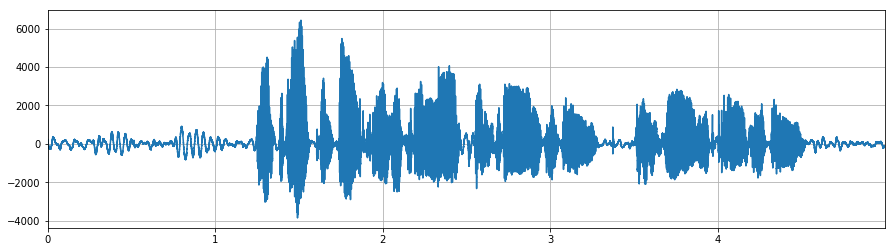

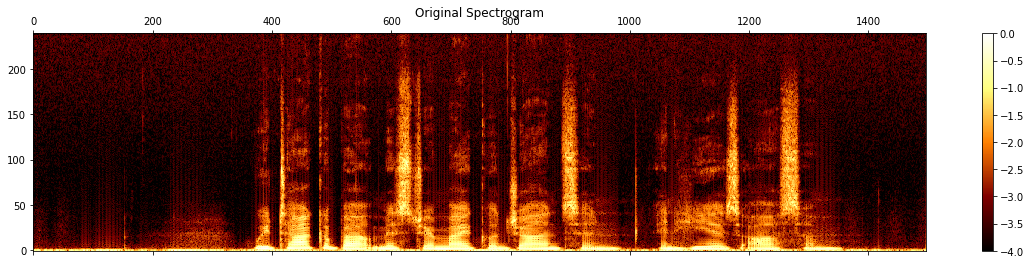

In [295]:
#
b_gen_from_text = False

if b_gen_from_text:
    # generate from free text
    text = 'see that girl watch that scene'
    npz_file = ''
    
else:
    # generate based on an existing VCTK sample
    source_speaker_id = 12
    sample_id = 230
    text = ''

    vctk_source_speaker_id = int(speaker_lookup[source_speaker_id])
    npz_file= 'p' + str(vctk_source_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz'
    
    # display/listen to the VCTK sample
    display_vctk_sample(vctk_source_speaker_id, sample_id, 
                        save_folder=output_dir, 
                        fname=os.path.join(output_dir, npz_file[:-4] + '_orig'))

#### Define which voice to use for synthesis

In [296]:
# speaker id to use for VoiceLoop generation
gen_speaker_id = 12

speaker_info[speaker_info.id==[speaker_lookup[gen_speaker_id]]]

id  age gender   accents region
330  330   26      F  American

#### Synthesize the sample with the specified speaker

In [297]:
# generate the sample
loop_dict = generate_sample_with_loop(spkr_id=gen_speaker_id, npz=npz_file, text=text, checkpoint=checkpoint, 
                                      output_dir=output_dir,
                                     b_eval_mode=True)

False
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230_12.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.orig.wav.


In [298]:
# listen to sample synthesized with original WORLD features
if b_gen_from_text==False:
    IPython.display.display(Audio(os.path.join(output_dir, loop_dict['output_orig_fname'] + '.wav'), autoplay=True))

In [299]:
# listen to sample synthesized from VoiceLoop features
IPython.display.display(Audio(os.path.join(output_dir, loop_dict['output_file'] + '.wav'), autoplay=True))

In [85]:
loop_dict['output_file'] + '.wav'

'p330_230_2.wav'

#### Code to generate markdown for GitHub pages

In [528]:
for gen_speaker_id in range(21):
    #display(speaker_info[speaker_info.id==[speaker_lookup[gen_speaker_id]]])
    s = speaker_info[speaker_info.id==[speaker_lookup[gen_speaker_id]]]
    #print '| ' + str(s['id'].values[0]) + ' | ' + str(s['gender'].values[0]) + ' | ' + str(s['age'].values[0]) + ' | ' + str(s['accents'].values[0]) + ' | ' + str(s['region'].values[0]) \
    print '| ' + str(s['id'].values[0]) \
    + ' | <audio src="master/world_features_exploration/p' + str(str(s['id'].values[0])) + '_001.orig.wav" controls></audio>' \
    + ' | <audio src="master/world_features_exploration/p' + str(str(s['id'].values[0])) + '_001' + '_' + str(gen_speaker_id) + '.wav" controls></audio>' \
    + ' | <audio src="master/world_features_exploration/p' + str(str(s['id'].values[0])) + '_198.orig.wav" controls></audio>' \
    + ' | <audio src="master/world_features_exploration/p330_230_' + str(gen_speaker_id) + '.wav" controls></audio>' \
    + ' | '

| 294 | <audio src="master/world_features_exploration/p294_001.orig.wav" controls></audio> | <audio src="master/world_features_exploration/p294_001_0.wav" controls></audio> | <audio src="master/world_features_exploration/p294_198.orig.wav" controls></audio> | <audio src="master/world_features_exploration/p330_230_0.wav" controls></audio> | 
| 297 | <audio src="master/world_features_exploration/p297_001.orig.wav" controls></audio> | <audio src="master/world_features_exploration/p297_001_1.wav" controls></audio> | <audio src="master/world_features_exploration/p297_198.orig.wav" controls></audio> | <audio src="master/world_features_exploration/p330_230_1.wav" controls></audio> | 
| 299 | <audio src="master/world_features_exploration/p299_001.orig.wav" controls></audio> | <audio src="master/world_features_exploration/p299_001_2.wav" controls></audio> | <audio src="master/world_features_exploration/p299_198.orig.wav" controls></audio> | <audio src="master/world_features_exploration/p330_230

In [538]:
for gen_speaker_id in range(21):
    #display(speaker_info[speaker_info.id==[speaker_lookup[gen_speaker_id]]])
    s = speaker_info[speaker_info.id==[speaker_lookup[gen_speaker_id]]]
    #print '| ' + str(s['id'].values[0]) + ' | ' + str(s['gender'].values[0]) + ' | ' + str(s['age'].values[0]) + ' | ' + str(s['accents'].values[0]) + ' | ' + str(s['region'].values[0]) \
    #print '| ' + str(s['id'].values[0]) \
    print ' | <audio src="master/world_features_exploration/p' + str(str(s['id'].values[0])) + '_001.orig.wav" controls></audio>' \
    + ' | <audio src="master/world_features_exploration/p' + str(str(s['id'].values[0])) + '_198.orig.wav" controls></audio>' \
    + ' | **' + str(s['id'].values[0]) + '**'\
    + ' | <audio src="master/world_features_exploration/p' + str(str(s['id'].values[0])) + '_001' + '_' + str(gen_speaker_id) + '.wav" controls></audio>' \
    + ' | <audio src="master/world_features_exploration/p330_230_' + str(gen_speaker_id) + '.wav" controls></audio>' \
    + ' | '

 | <audio src="master/world_features_exploration/p294_001.orig.wav" controls></audio> | <audio src="master/world_features_exploration/p294_198.orig.wav" controls></audio> | **294** | <audio src="master/world_features_exploration/p294_001_0.wav" controls></audio> | <audio src="master/world_features_exploration/p330_230_0.wav" controls></audio> | 
 | <audio src="master/world_features_exploration/p297_001.orig.wav" controls></audio> | <audio src="master/world_features_exploration/p297_198.orig.wav" controls></audio> | **297** | <audio src="master/world_features_exploration/p297_001_1.wav" controls></audio> | <audio src="master/world_features_exploration/p330_230_1.wav" controls></audio> | 
 | <audio src="master/world_features_exploration/p299_001.orig.wav" controls></audio> | <audio src="master/world_features_exploration/p299_198.orig.wav" controls></audio> | **299** | <audio src="master/world_features_exploration/p299_001_2.wav" controls></audio> | <audio src="master/world_features_explo

## 3) Comparison of Speech Samples
* Listen to and visualise the differences between speech for the same text but generated in different ways, or with different speaker voices
* a) First pick which samples you want to compare
* c) Then run various comparisons 

### a) Pick Voice Samples
#### i) Compare the VoiceLoop Sample to the Original (same speaker)
* Run either i) or ii)
* Then move on to part b)

In [277]:
assert not b_gen_from_text, "Only works for synthesis based on VCTK samples"
loop_dict = generate_sample_with_loop(spkr_id=source_speaker_id, npz=npz_file, text='', checkpoint=checkpoint)
fname_a = loop_dict['output_orig_fname']
fname_b = loop_dict['output_file']
feats_a = loop_dict['feat'].squeeze()
feats_b = loop_dict['loop_feat'].squeeze()
label_a = 'WORLD'
label_b = 'Loop_SameSpkr'

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230_12.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.orig.wav.


#### ii) Compare VoiceLoop sample generated for a different speaker to the original VCTK sample

In [36]:
assert not b_gen_from_text, "Only works for synthesis based on VCTK samples"
loop_dict = generate_sample_with_loop(spkr_id=gen_speaker_id, npz=npz_file, text='', checkpoint=checkpoint)
fname_a = loop_dict['output_orig_fname']
fname_b = loop_dict['output_file']
feats_a = loop_dict['feat'].squeeze()
feats_b = loop_dict['loop_feat'].squeeze()
label_a = 'WORLD'
label_b = 'Loop_DiffSpkr'

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.orig.wav.


#### iii) Compare two VoiceLoop samples, once generate in original speaker's voice and the other with a different speaker

In [231]:
loop_dict_source = generate_sample_with_loop(spkr_id=source_speaker_id, npz=npz_file, text=text, checkpoint=checkpoint)
fname_a = loop_dict_source['output_file']
feats_a = loop_dict_source['loop_feat'].squeeze()

loop_dict = generate_sample_with_loop(spkr_id=gen_speaker_id, npz=npz_file, text=text, checkpoint=checkpoint)
fname_b = loop_dict['output_file']
feats_b = loop_dict['loop_feat'].squeeze()

label_a = 'Loop_OriginalSpkr'
label_b = 'Loop_DiffSpkr'

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230_12.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.orig.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230_12.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p330_230.orig.wav.


In [187]:
fname_b

'p330_230_14'

### b) Compare the Speech Samples
#### i) Listen to the audio

##### Original Sample

In [188]:
IPython.display.display(Audio(fname_a + '.wav', autoplay=True))

##### Test Sample

In [278]:
IPython.display.display(Audio(fname_b + '.wav', autoplay=True))

In [39]:
# the pre-calculated WORLD features from the .npz file
#loop_dict['pre_calc_feat'].keys()

#### ii) Spectrogram Comparison

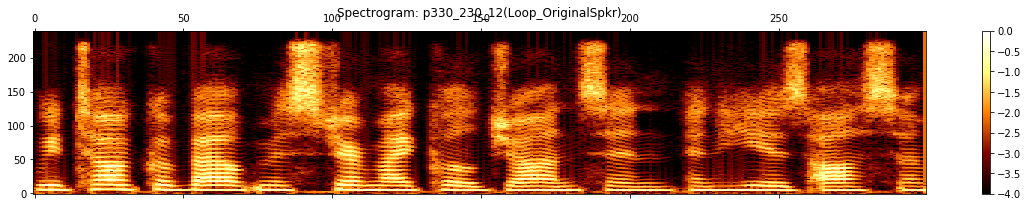

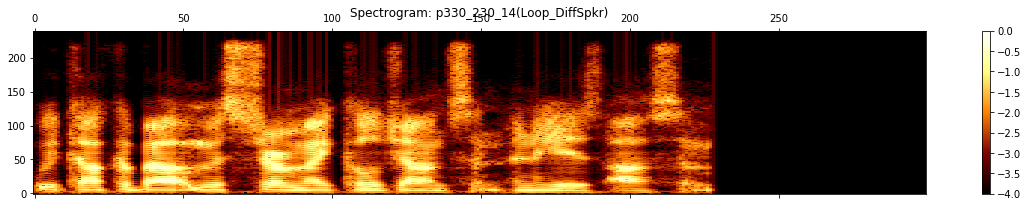

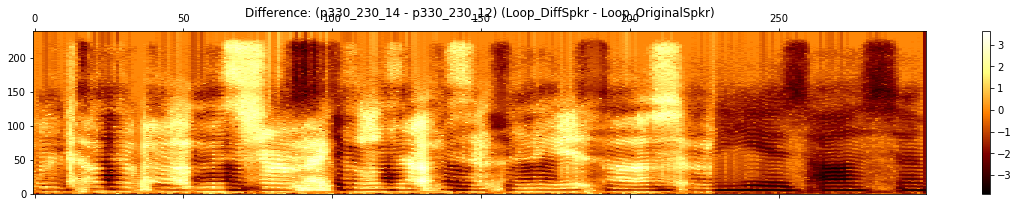

In [190]:
fname = os.path.join(output_dir, 'michael_johnson_spectro_diff_diff_spkr_14')
plot_spectrogram_comparison(fname_a, fname_b, label_a, label_b, b_mel=False, fname=fname)


#### iii) Feature Comparison

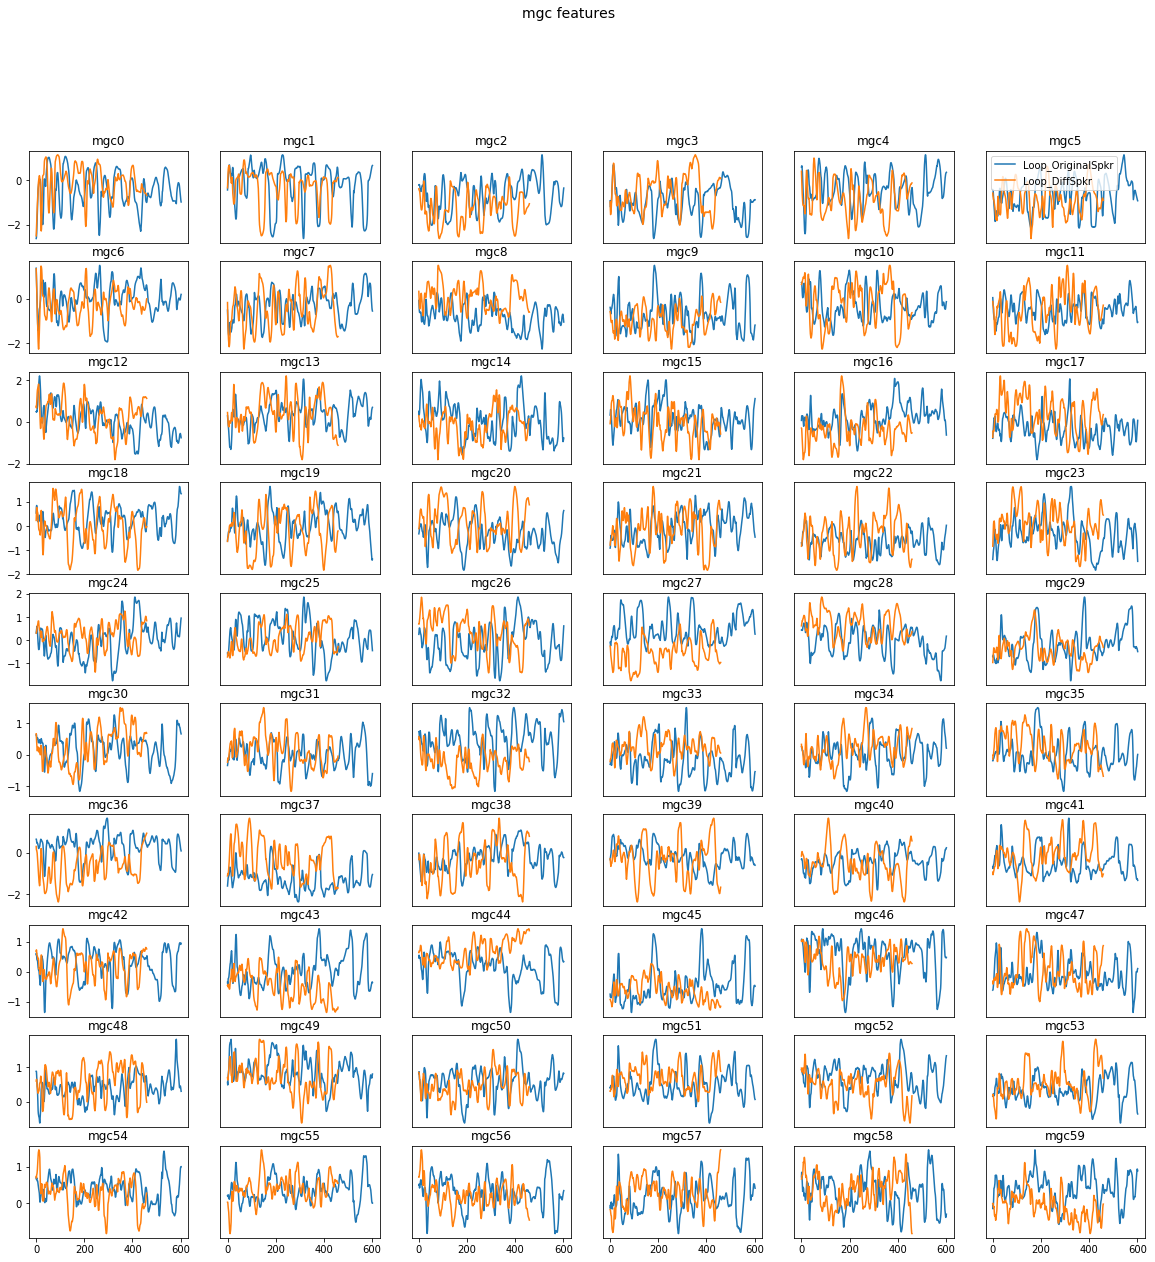

In [191]:
fname = os.path.join(output_dir, 'michael_johnson_mgc_diff_spkr_14')
plot_mgc_feature_comparison(feats_a, feats_b, label_a, label_b, fname=fname)

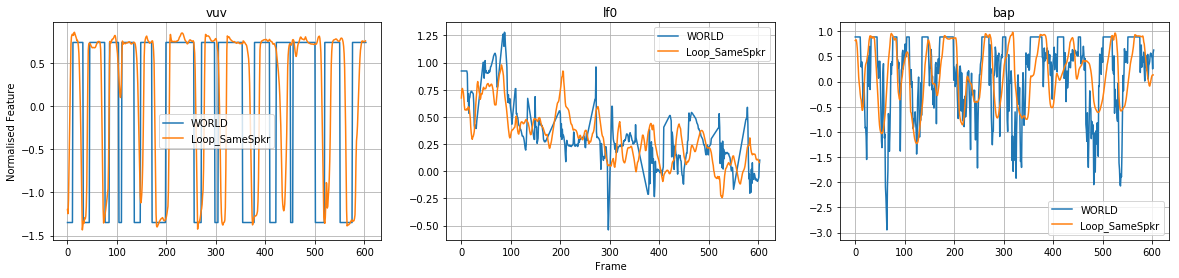

In [279]:
fname = os.path.join(output_dir, 'michael_johnson_main_feat_diff_spkr_14')
plot_other_feature_comparison(feats_a, feats_b, label_a, label_b, fname=fname)

#### iv) Attention Comparison

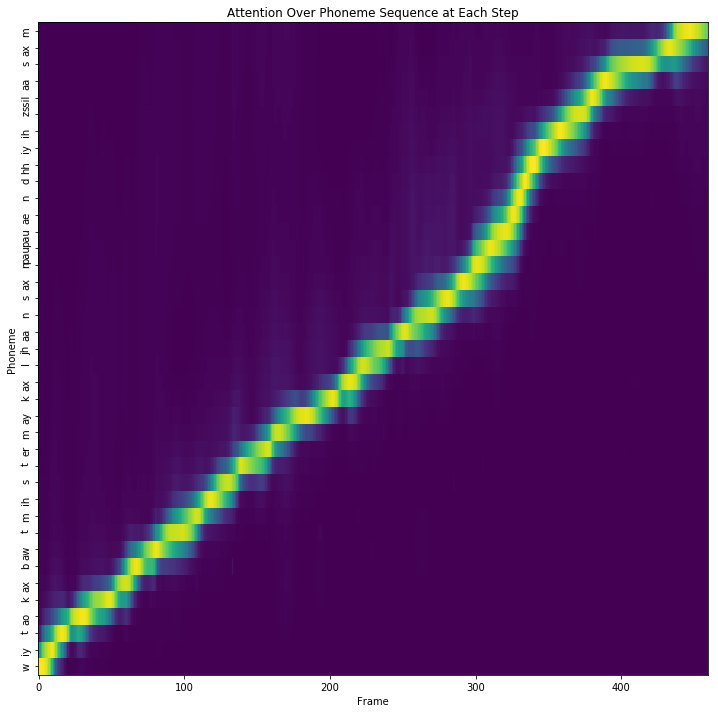

In [193]:
title_str = 'Attention Over Phoneme Sequence at Each Step'
fname = os.path.join(output_dir, 'michael_johnson_attn_diff_spkr')
plot_attn(loop_dict['attn'], loop_dict['txt'], NpzFolder(loop_dict['valid_dataset_path']).dict, title=title_str, fname=fname)

## 4) Hack Features & Listen to the Impact
* Take the original WORLD features for an utterance
* Modify them manually
* Synthesize the results and compare to the original
* Note that none of this section uses the VoiceLoop code

#### Method 1) Deterministic modification to single feature

In [194]:
# hack methods
flat = lambda x: np.zeros(x.shape)

sq = lambda x, y, add=1, mult=1: add*x + mult * np.square(np.linspace(0, y, x.shape[0]))

power_hack = lambda x, scale=1, add=1, p=2, mult=1, shift=0: add*x + mult* np.power(np.linspace(-scale, scale, x.shape[0]), p) + shift

In [248]:
hack_method = power_hack

# specify which feature to hack
idx_feat_to_hack = 61 # lf0
#idx_feat_to_hack = 2 # mgc1
#idx_feat_to_hack = 60 # vuv
#idx_feat_to_hack = 62 # bap

# specify hack method

hack_args = [1, 2, 0, 0, 0] # scale, add, power, mult, shift
hack_args = [1, 0, 2, 4, -1] # scale, add, power, mult, shift
hack_args = [1, 0, 2, 4, -1] # scale, add, power, mult, shift


idx_feat_to_hack = 60 # vuv
hack_args = [1, 0, 0, 0, -1] # scale, add, power, mult, shift
hack_args = [1, 0, 0, 0, 1] # scale, add, power, mult, shift
hack_args = [1, 0, 1, -10, 0] # scale, add, power, mult, shift
#hack_args = [1, 1, 0, 0, 0] # scale, add, power, mult, shift

idx_feat_to_hack = 61 # lf0
#hack_args = [1, 2, 0, 0, 0] # scale, add, power, mult, shift
#hack_args = [1, 0, 2, 4, -1] # scale, add, power, mult, shift
hack_args = [1, 0, 2, 3, -1] # scale, add, power, mult, shift

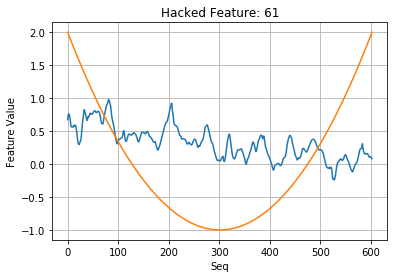

In [253]:
# modify feature values
hack_feat = copy.deepcopy(feats_a)
hack_feat[:, idx_feat_to_hack] = hack_method(hack_feat[:, idx_feat_to_hack], *hack_args)

plt.plot(feats_a[:, idx_feat_to_hack])
plt.plot(hack_feat[:, idx_feat_to_hack])
plt.grid(True)
plt.xlabel('Seq')
plt.ylabel('Feature Value')
plt.title('Hacked Feature: ' + str(idx_feat_to_hack))

output_file_hack = 'michael_johnson_lf0_' + '_hack'

#### Method 2) Add random noise to all features

In [76]:
# add normal noise to all features
std = 0.05

# modify feature values
hack_feat = copy.deepcopy(feats_a)

for i in range(feats_a.shape[1]):
    # random noise at each time step
    #hack_feat[:, i] += np.random.normal(size=feats_a.shape[0], scale=std, loc=0)
    
    # cumulative noise
    hack_feat[:, i] += np.cumsum(np.random.normal(size=feats_a.shape[0], scale=std, loc=0))

output_file_hack = output_file + '_hack'

### Generate .wav file from modified WORLD features

In [256]:
generate_merlin_wav(hack_feat[:, :],
                    output_dir,
                    output_file_hack,
                    norm_path)

Audio(os.path.join(output_dir, output_file_hack + '.wav'), autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete michael_johnson_lf0__hack.wav.


In [255]:
# original
IPython.display.display(Audio(os.path.join(output_dir, fname_a + '.wav'), autoplay=True))

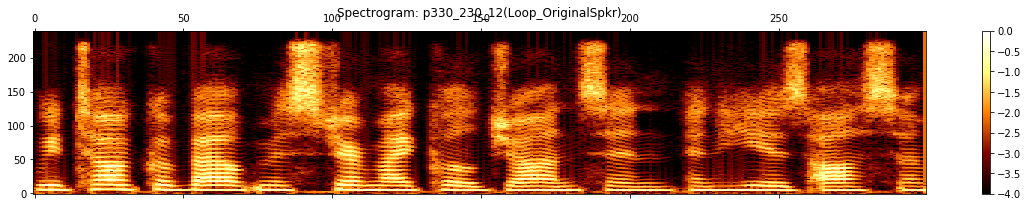

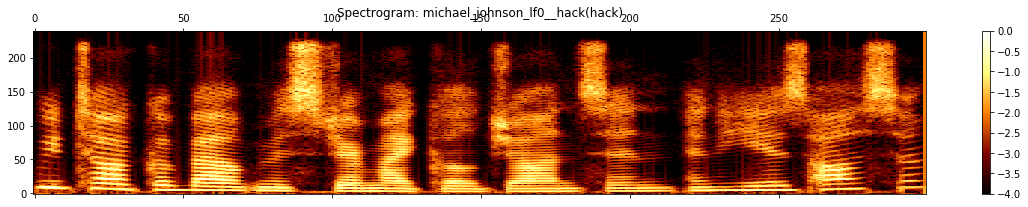

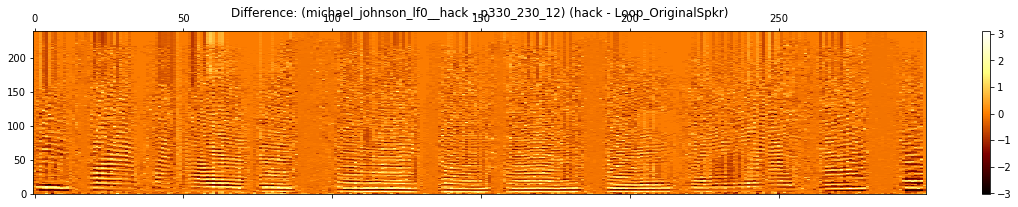

In [261]:
fname = os.path.join(output_dir, 'michael_johnson_hack_spectro')
plot_spectrogram_comparison(fname_a, os.path.join(output_dir, output_file_hack), label_a, 'hack', b_mel=False, fname=fname)

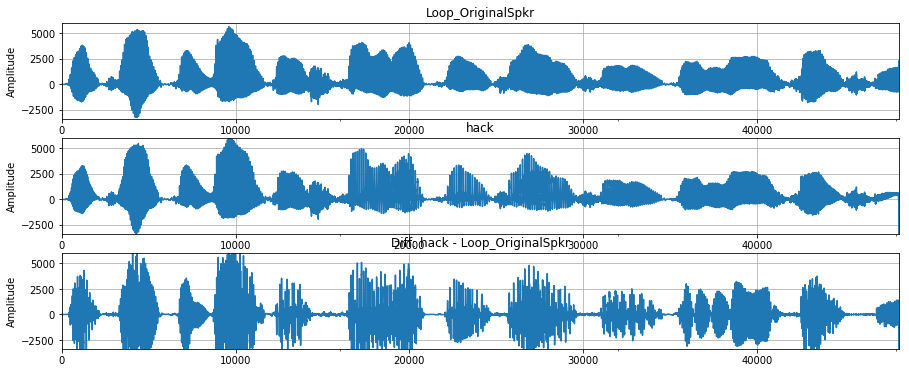

In [263]:
plot_waveform_comparison(os.path.join(output_dir, fname_a), os.path.join(output_dir, output_file_hack), label_a, 'hack')

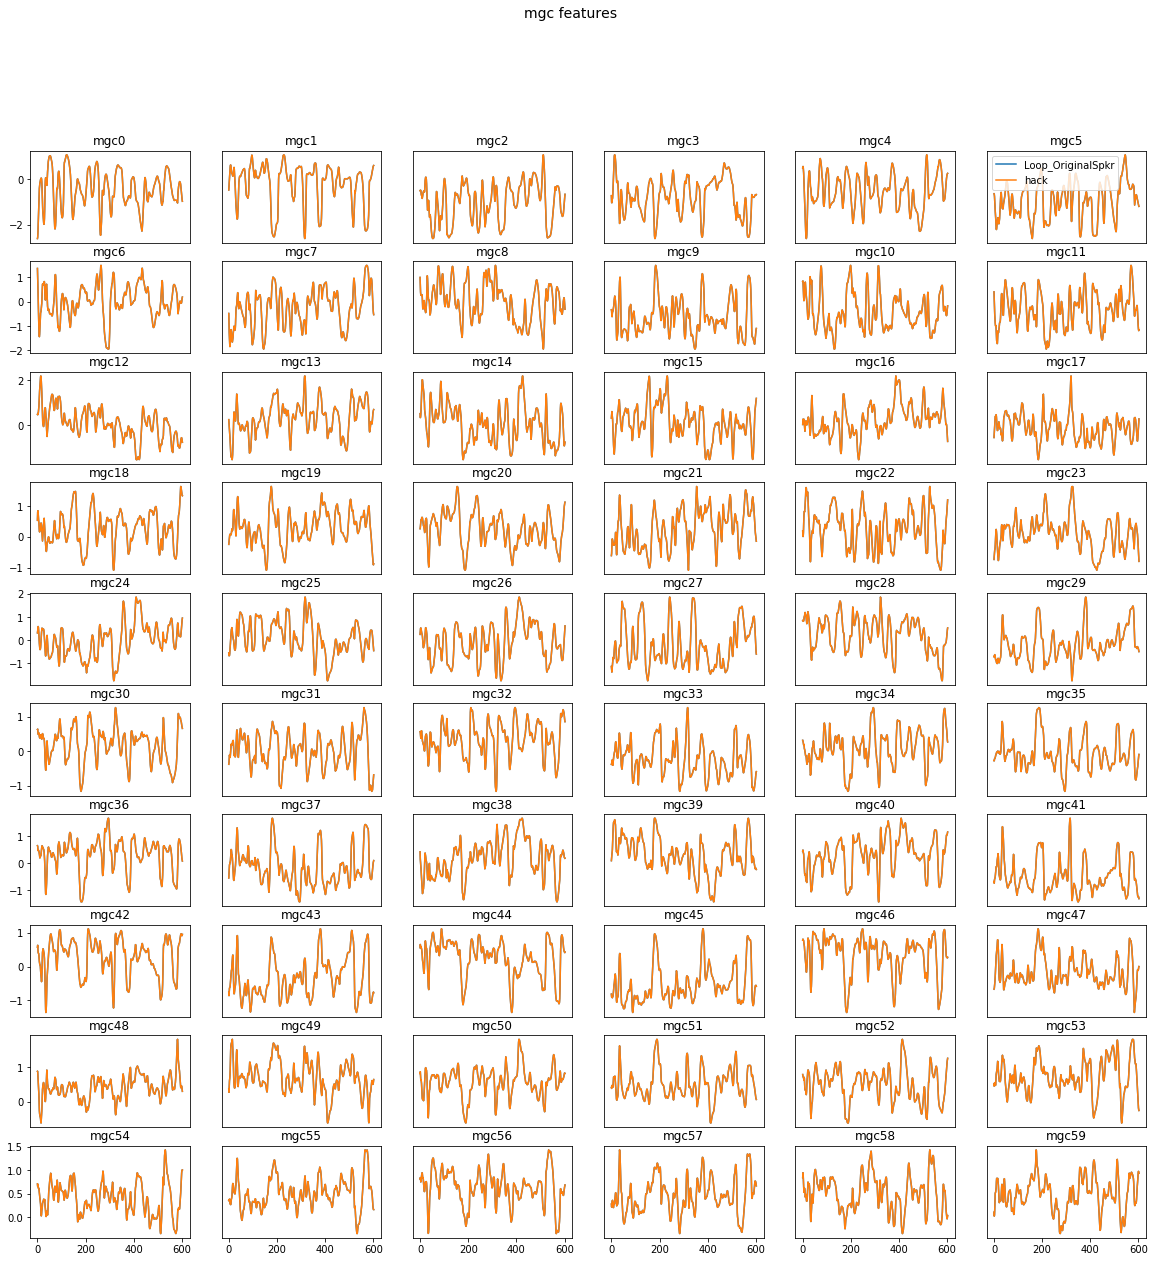

In [264]:
plot_mgc_feature_comparison(feats_a, hack_feat, label_a, 'hack')

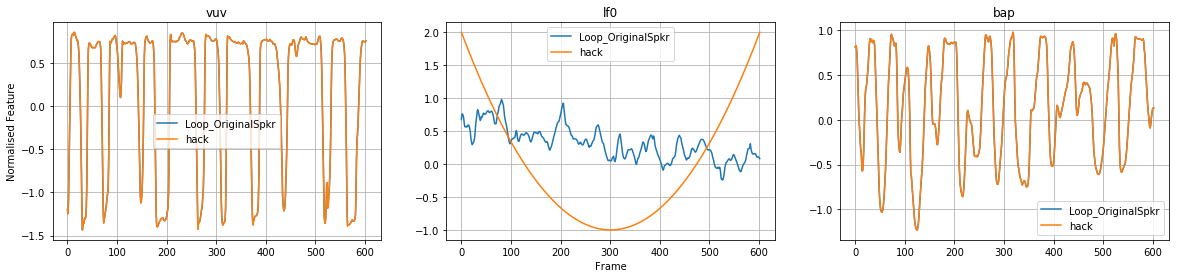

In [258]:
fname = os.path.join(output_dir, 'michael_johnson_hack_main_feats')
plot_other_feature_comparison(feats_a, hack_feat, label_a, 'hack', fname=fname)

### Product some samples for the other US speakers
* Want these as reference points for the "We talk about Mr. Michael Johnson..." samples

In [303]:
# load VCTK speaker_info metadata
speaker_info = get_vtck_speaker_info()
#speaker_info[speaker_info.id.isin(speaker_lookup.values())]
tmp = pd.DataFrame.from_dict(speaker_lookup, orient='index', columns=['id'])
pd.merge(speaker_info, tmp)

id  age gender   accents          region
0   294   33      F  American   San Francisco
1   297   20      F  American        New York
2   299   25      F  American      California
3   300   23      F  American      California
4   301   23      F  American  North Carolina
5   305   19      F  American    Philadelphia
6   306   21      F  American        New York
7   308   18      F  American         Alabama
8   310   21      F  American       Tennessee
9   311   21      M  American            Iowa
10  318   32      F  American            Napa
11  329   23      F  American                
12  330   26      F  American                
13  333   19      F  American         Indiana
14  334   18      M  American         Chicago
15  339   21      F  American    Pennsylvania
16  341   26      F  American            Ohio
17  345   22      M  American         Florida
18  360   19      M  American      New Jersey
19  361   19      F  American      New Jersey
20  362   29      F  American

In [490]:
speaker_id = 20
sample_id = 198
text = ''

vctk_source_speaker_id = int(speaker_lookup[speaker_id])
npz_file= 'p' + str(vctk_source_speaker_id) + '_' + '{num:03d}'.format(num=sample_id) + '.npz'


In [491]:
# generate the sample
loop_dict = generate_sample_with_loop(spkr_id=speaker_id, npz=npz_file, text=text, checkpoint=checkpoint, 
                                      output_dir=output_dir,
                                     b_eval_mode=True)

False
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p362_198_20.wav.
{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete p362_198.orig.wav.


In [492]:
# listen to sample synthesized with original WORLD features
if b_gen_from_text==False:
    IPython.display.display(Audio(os.path.join(output_dir, loop_dict['output_orig_fname'] + '.wav'), autoplay=True))

In [493]:
# listen to sample synthesized from VoiceLoop features
IPython.display.display(Audio(os.path.join(output_dir, loop_dict['output_file'] + '.wav'), autoplay=True))

## Product some samples for VCTK-All-107
* Might as well keep this in the same notebook for ease
* Just want some examples for the webpage to show that the model can represent different accents